In [1]:
# To do
# -----
# 1. try to run from matlab
# 2. try in windows computer
# 3. end tramslate saccade model to python
# 4. define all saccade metrics
# 5. rotate all data per eccentricity to fit 2D non isometric gaussian on distibution of landing point

# 6. apply anemo model to smooth pursuit eye traces rotated to main axis

# Stop warnings
# -------------
import warnings
warnings.filterwarnings("ignore")

# General imports
# ---------------
import os
import sys
import platform
import numpy as np
import ipdb
import json
import h5py
import scipy.io
import cortex
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors as colors
deb = ipdb.set_trace

# Get inputs
# ----------
subject = 'sub-01'
task = 'EyeMov'

# Define analysis parameters
# --------------------------
with open('../behavior_settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)

# Platform settings 
# -----------------
if platform.system() == 'Darwin':
    main_dir = analysis_info['main_dir_mac']
    
elif platform.system() == 'Windows':
    main_dir = analysis_info['main_dir_pc']

# Define experiments details
# --------------------------
num_run = analysis_info['num_run']
seq_trs = analysis_info['seq_trs']
eye_mov_seq = analysis_info['eye_mov_seq']
rads = analysis_info['rads']
pursuits_tr = np.arange(0,seq_trs,2)
saccades_tr = np.arange(1,seq_trs,2)


# Load data
# ---------
file_dir = '{exp_dir}/data/{sub}'.format(exp_dir = main_dir, sub = subject)
h5_filename = "{file_dir}/add/{sub}_task-{task}_eyedata.h5".format(file_dir = file_dir, sub = subject, task = task)
h5_file = h5py.File(h5_filename,'r')
folder_alias = 'eye_traces'
eye_data_runs_no_blink = np.array(h5_file['{folder_alias}/eye_data_runs_no_blink'.format(folder_alias = folder_alias)])
eye_data_runs = np.array(h5_file['{folder_alias}/eye_data_runs'.format(folder_alias = folder_alias)])
time_start_seq = np.array(h5_file['{folder_alias}/time_start_seq'.format(folder_alias = folder_alias)])
time_end_seq = np.array(h5_file['{folder_alias}/time_end_seq'.format(folder_alias = folder_alias)])

time_start_trial = np.array(h5_file['{folder_alias}/time_start_trial'.format(folder_alias = folder_alias)])
time_end_trial = np.array(h5_file['{folder_alias}/time_end_trial'.format(folder_alias = folder_alias)])
amp_sequence = np.array(h5_file['{folder_alias}/amp_sequence'.format(folder_alias = folder_alias)])


In [2]:
# Saccade analysis per run and sequence
# Define figure
title_font = {'loc':'left', 'fontsize':14, 'fontweight':'bold'}
axis_label_font = {'fontsize':14}
bg_col = (0.9, 0.9, 0.9)
axis_width = 0.75
line_width_corr = 1.5

# Horizontal eye trace
screen_val =  12.5
ymin1,ymax1,y_tick_num1 = -screen_val,screen_val,11
y_tick1 = np.linspace(ymin1,ymax1,y_tick_num1)
xmin1,xmax1,x_tick_num1 = 0,1,5
xmin2,xmax2,x_tick_num2 = 0,1,5
x_tick1 = np.linspace(xmin1,xmax1,x_tick_num1)
x_tick2 = np.linspace(xmin2,xmax2,x_tick_num2)

# Vertical eye trace
ymin2,ymax2,y_tick_num2 = -screen_val,screen_val,11
xmin2,xmax2,x_tick_num2 = 0,1,num_run+1
y_tick2 = np.linspace(ymin2,ymax2,y_tick_num2)
x_tick2 = np.linspace(xmin2,xmax2,x_tick_num2)

try: os.makedirs('{file_dir}/add/figures/'.format(file_dir = file_dir))
except: pass

cmap = 'hsv'
cmap_steps = 16
col_offset = 0#1/14.0
base = cortex.utils.get_cmap(cmap)
val = np.linspace(0, 1,cmap_steps+1,endpoint=False)
colmap = colors.LinearSegmentedColormap.from_list('my_colmap',base(val), N = cmap_steps)

pursuit_polar_ang = np.deg2rad(np.arange(0,360,22.5))
pursuit_ang_norm  = (pursuit_polar_ang + np.pi) / (np.pi * 2.0)
pursuit_ang_norm  = (np.fmod(pursuit_ang_norm + col_offset,1))*cmap_steps

pursuit_col_mat = colmap(pursuit_ang_norm.astype(int))
pursuit_col_mat[:,3]=0.2

saccade_polar_ang = np.deg2rad(np.arange(0,360,22.5)+180)
saccade_ang_norm  = (saccade_polar_ang + np.pi) / (np.pi * 2.0)
saccade_ang_norm  = (np.fmod(saccade_ang_norm + col_offset,1))*cmap_steps

saccade_col_mat = colmap(saccade_ang_norm.astype(int))
saccade_col_mat[:,3] = 0.8


polar_ang = np.deg2rad(np.arange(0,360,22.5))
trials_seq = saccades_tr


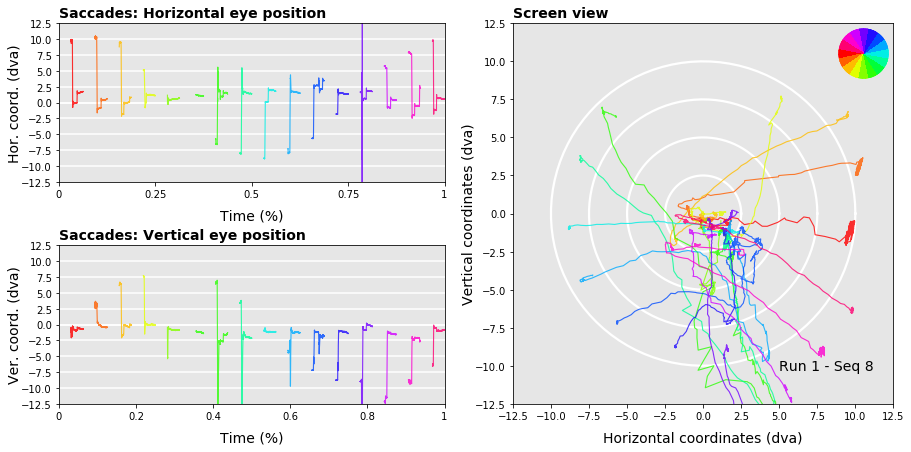

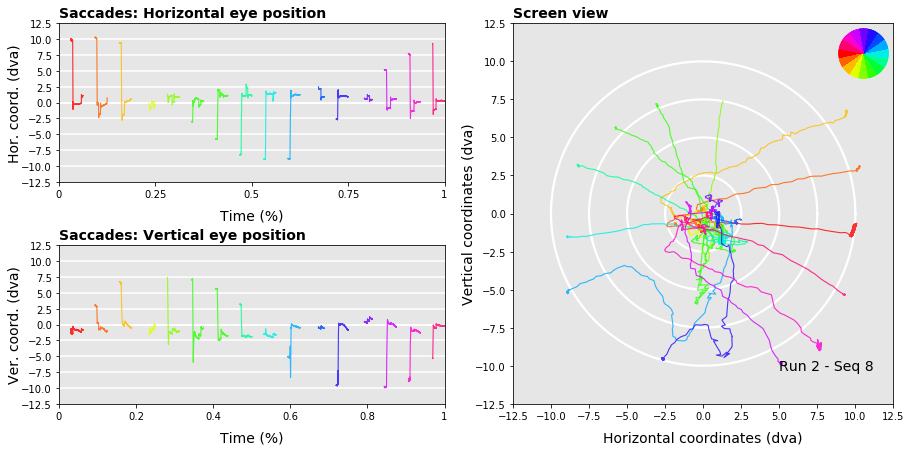

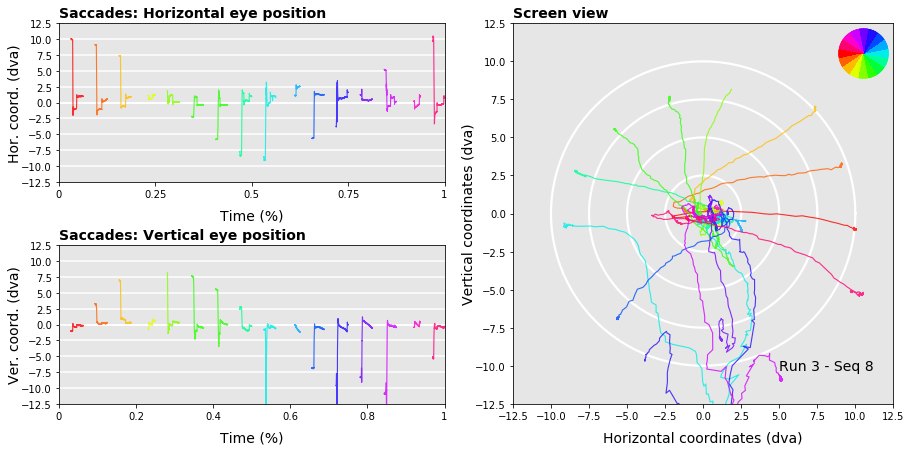

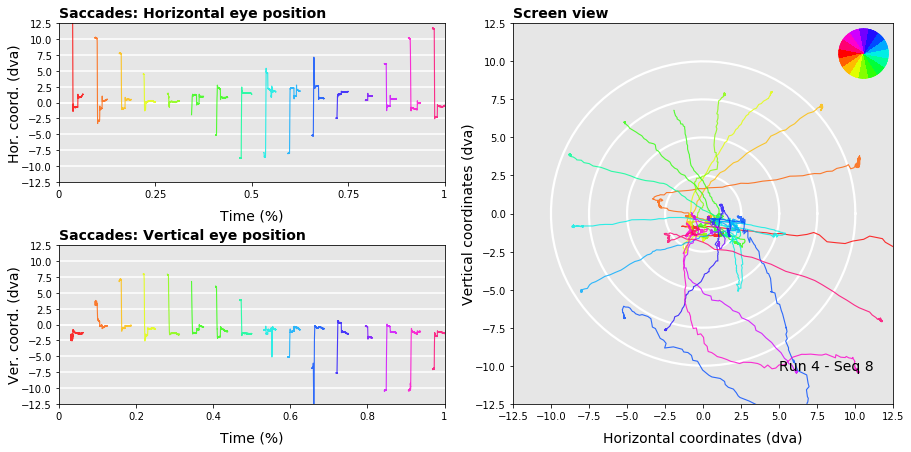

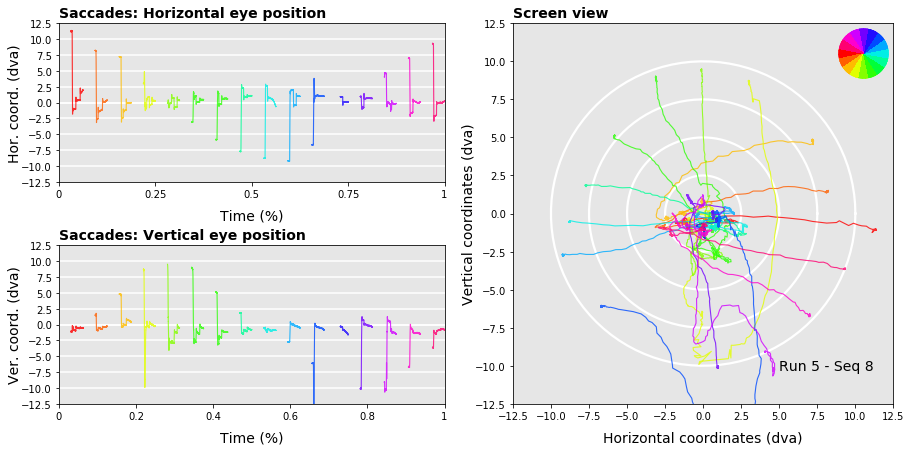

In [3]:
for run_plot in np.arange(0,num_run,1):
    
    # define run name
    if run_plot > 9:
        run_plot_txt = '{}'.format(run_plot+1)
    else:
        run_plot_txt = '0{}'.format(run_plot+1)

    # Define figure folder
    try: os.makedirs('{file_dir}/add/figures/run_{run_plot_txt}'.format(file_dir = file_dir,run_plot_txt = run_plot_txt))
    except: pass
    
    fig = plt.figure(figsize = (15, 7))
    gridspec.GridSpec(2,8)
    run_data_logic = eye_data_runs_no_blink[:,3] == run_plot
    
    for seq_plot in eye_mov_seq:
        
        # define seq name
        if seq_plot > 9:
            seq_plot_txt = '{}'.format(seq_plot+1)
        else:
            seq_plot_txt = '0{}'.format(seq_plot+1)

        seq_data_logic = np.logical_and(eye_data_runs_no_blink[:,0] >= time_start_seq[seq_plot,run_plot],
                                        eye_data_runs_no_blink[:,0] <= time_end_seq[seq_plot,run_plot])
        
        dur_seq = time_end_seq[seq_plot,run_plot]-time_start_seq[seq_plot,run_plot]
        
        # Horizontal eye trace
        ax1 = plt.subplot2grid((2,8),(0,0),rowspan= 1, colspan = 4)
        ax1.set_ylabel('Hor. coord. (dva)',axis_label_font,labelpad = 0)
        ax1.set_ylim(bottom = ymin1, top = ymax1)
        ax1.set_yticks(y_tick1)
        ax1.set_xlabel('Time (%)',axis_label_font,labelpad = 10)
        ax1.set_xlim(left = xmin1, right = xmax1)
        ax1.set_xticks(x_tick1)
        ax1.set_facecolor(bg_col)
        ax1.set_title('Saccades: Horizontal eye position',**title_font)
        ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2g'))

        for rad in rads:
            ax1.plot(x_tick1,x_tick1*0+rad, color = [1,1,1], linewidth = axis_width*2)
            ax1.plot(x_tick1,x_tick1*0-rad, color = [1,1,1], linewidth = axis_width*2)

        # Vertical eye trace
        ax2 = plt.subplot2grid((2,8),(1,0),rowspan= 1, colspan = 4)
        ax2.set_ylabel('Ver. coord. (dva)',axis_label_font, labelpad = 0)
        ax2.set_ylim(bottom = ymin2, top = ymax2)
        ax2.set_yticks(y_tick2)
        ax2.set_xlabel('Time (%)',axis_label_font, labelpad = 10)
        ax2.set_xlim(left = xmin2, right = xmax2)
        ax2.set_xticks(x_tick2)
        ax2.set_facecolor(bg_col)
        ax2.set_title('Saccades: Vertical eye position',**title_font)
        ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2g'))
        for rad in rads:
            ax2.plot(x_tick2,x_tick2*0+rad, color = [1,1,1], linewidth = axis_width*2)
            ax2.plot(x_tick2,x_tick2*0-rad, color = [1,1,1], linewidth = axis_width*2)

        # Screen eye trace
        ax3 = plt.subplot2grid((2,8),(0,4),rowspan= 2, colspan = 4)
        ax3.set_xlabel('Horizontal coordinates (dva)', axis_label_font, labelpad = 10)
        ax3.set_ylabel('Vertical coordinates (dva)', axis_label_font, labelpad = 0)
        ax3.set_xlim(left = ymin1, right = ymax1)
        ax3.set_xticks(y_tick1)
        ax3.set_ylim(bottom = ymin2, top = ymax2)
        ax3.set_yticks(y_tick2)
        ax3.set_facecolor(bg_col)
        ax3.set_title('Screen view',**title_font)
        ax3.set_aspect('equal')

        theta = np.linspace(0, 2*np.pi, 100)
        for rad in rads:
            ax3.plot(rad*np.cos(theta), rad*np.sin(theta),color = [1,1,1],linewidth = axis_width*3)
            
        
            

        ax3.text(5, -10, 'Run {run_plot} - Seq {seq_plot}'.format(run_plot = run_plot+1, seq_plot = seq_plot+1), horizontalalignment = 'left', verticalalignment = 'center', fontsize = 14)

            
        for trial_num,trial_plot in enumerate(trials_seq):
            trial_data_logic = np.logical_and(eye_data_runs_no_blink[:,0] >= time_start_trial[trial_plot,seq_plot,run_plot],
                                              eye_data_runs_no_blink[:,0] <= time_end_trial[trial_plot,seq_plot,run_plot])
            
            data_logic = np.logical_and.reduce(np.array((run_data_logic,seq_data_logic,trial_data_logic)))
            
            time_prct = ((eye_data_runs_no_blink[data_logic][:,0]- time_start_seq[seq_plot,run_plot])/dur_seq)
        
            plot_color = saccade_col_mat[trial_num,:]
        
            ax1.plot(time_prct,eye_data_runs_no_blink[data_logic,1],color = plot_color,linewidth = axis_width*1.5)
            ax2.plot(time_prct,eye_data_runs_no_blink[data_logic,2],color = plot_color,linewidth = axis_width*1.5)
            ax3.plot(eye_data_runs_no_blink[data_logic,1],eye_data_runs_no_blink[data_logic,2],color = plot_color,linewidth = axis_width*1.5)
        
        plt.subplots_adjust(wspace = 1.4,hspace = 0.4)

        # color legend
        cbar_axis = fig.add_axes([0.47, 0.77, 0.8, 0.1], projection='polar')
        norm = colors.Normalize(0, 2*np.pi)
        t = np.linspace(0,2*np.pi,200,endpoint=True)
        r = [0,1]
        rg, tg = np.meshgrid(r,t)
        im = cbar_axis.pcolormesh(t, r, tg.T,norm= norm, cmap = colmap)
        cbar_axis.set_yticklabels([])
        cbar_axis.set_xticklabels([])
        cbar_axis.set_theta_zero_location("W",offset = -360/cmap_steps/2)
        cbar_axis.spines['polar'].set_visible(False)
        
        plt.savefig("{file_dir}/add/figures/run_{run_plot_txt}/{sub}_task-{task}_run-{run_plot_txt}_seq-{seq_plot_txt}_eyetraces.png".format(
                                                                sub = subject,
                                                                task = task,
                                                                run_plot_txt = run_plot_txt,
                                                                seq_plot_txt = seq_plot_txt,
                                                                file_dir = file_dir, 
                                                                run_plot = run_plot),facecolor='w')

In [5]:
def vecvel(x,y,sampling_rate):
    """
    ----------------------------------------------------------------------
    vecvel(x,y,sampling_rate)
    ---------------------------------------------------------------------- 
    Goal of the function :
    Compute eye velocity
    ----------------------------------------------------------------------
    Input(s) :
    x: raw data, horizontal components of the time series
    y: raw data, vertical components of the time series
    samplign_rate: eye tracking sampling rate
    ----------------------------------------------------------------------
    Output(s) :
    vx: velocity, horizontal component 
    vy: velocity, vertical component
    ----------------------------------------------------------------------
    Function created by Martin Rolfs
    adapted by Martin SZINTE (mail@martinszinte.net) 
    ----------------------------------------------------------------------
    """
    import numpy as np

    n = x.size

    vx = np.zeros_like(x)
    vy = np.zeros_like(y)

    vx[2:n-3] = sampling_rate/6 * x[4:-1] + x[3:-2] - x[1:-4] - x[0:-5]
    vx[1] = sampling_rate/2*(x[2] - x[0]);
    vx[-2] = sampling_rate/2*(x[-1]-x[-3])

    vy[2:n-3] = sampling_rate/6 * y[4:-1] + y[3:-2] - y[1:-4] - y[0:-5]
    vy[1] = sampling_rate/2*(y[2] - y[0]);
    vy[-2] = sampling_rate/2*(y[-1]-y[-3])

    return vx,vy

# def microsacc(x,y,vx,vy,velocity_th,min_dur,merge_interval)
#     """
#     ----------------------------------------------------------------------
#     microsacc(x,y,vx,vy,velocity_th,min_duration,merge_interval)
#     ---------------------------------------------------------------------- 
#     Goal of the function :
#     Detection of monocular candidates for microsaccades   
#     ----------------------------------------------------------------------
#     Input(s) :
#     x: raw data, horizontal components of the time series
#     y: raw data, vertical components of the time series
#     vx: velocity horizontal components of the time series
#     vy: velocity vertical components of the time series
#     velocity_th: velocity threshold
#     min_dur: saccade minimum duration
#     merge_interval: merge interval for subsequent saccade candidates
#     ----------------------------------------------------------------------
#     Output(s):
#     sac(1:num,1)   onset of saccade
#     sac(1:num,2)   end of saccade
#     sac(1:num,3)   peak velocity of saccade (vpeak)
#     sac(1:num,4)   horizontal component
#     sac(1:num,5)   vertical component
#     sac(1:num,6)   horizontal amplitude
#     sac(1:num,7)   vertical amplitude
#     ----------------------------------------------------------------------
#     Function created by Martin Rolfs
#     adapted by Martin SZINTE (mail@martinszinte.net) 
#     ----------------------------------------------------------------------
#     """
#     import numpy as np
    
#     # compute threshold
#     msdx = np.sqrt(np.median(vx.^2) - np.median(vx)^2)
#     msdy = np.sqrt(np.median(vy.^2) - np.median(vy)^2)
    
#     if msdx < np.nextafter(0,1):
#         msdx = np.sqrt(np.mean(vx.^2) - np.mean(vx)^2 )
#         if msdx < np.nextafter(0,1):
#             os.error('msdx < realmin')
            
#     if msdy < np.nextafter(0,1):
#         msdy = np.sqrt(np.mean(vy.^2) - np.mean(vy)^2 )
#         if msdy < np.nextafter(0,1):
#             os.error('msdy < realmin')

#     radiusx = velocity_th*msdx;
#     radiusy = velocity_th*msdy;

#     # compute test criterion: ellipse equation
#     test = (vx/radiusx).^2 + (vely/radiusy).^2;
#     indx = test>1;

#     # determine saccades
#     N = length(indx);
#     sac = [];
#     nsac = 0;
#     dur = 1;
#     a = 1;
#     k = 1;
#     while k < N
#         if indx(k+1)-indx(k)==1
#             dur = dur + 1;
#         else
#             if dur>=MINDUR
#                 nsac = nsac + 1;
#                 b = k;
#                 sac(nsac,:) = [indx(a) indx(b)];
#             end
#             a = k+1;
#             dur = 1;
#         end
#         k = k + 1;
#     end

#     % check for minimum duration
#     if dur>=MINDUR
#         nsac = nsac + 1;
#         b = k;
#         sac(nsac,:) = [indx(a) indx(b)];
#     end

#     % merge saccades
#     if ~isempty(sac)
#         msac = sac(1,:);    % merged saccade matrix
#         s    = 1;           % index of saccades in sac
#         sss  = 1;           % boolean for still same saccade
#         nsac = 1;           % number of saccades after merge
#         while s<size(sac,1)
#             if ~sss
#                 nsac = nsac + 1;
#                 msac(nsac,:) = sac(s,:);
#             end
#             if sac(s+1,1)-sac(s,2) <= mergeInterval
#                 msac(nsac,2) = sac(s+1,2);
#                 sss = 1;
#             else
#                 sss = 0;
#             end
#             s = s+1;
#         end
#         if ~sss
#             nsac = nsac + 1;
#             msac(nsac,:) = sac(s,:);
#         end
#     else
#         msac = [];
#         nsac = 0;
#     end

#     % compute peak velocity, horizonal and vertical components
#     for s=1:nsac
#         % onset and offset
#         a = msac(s,1);
#         b = msac(s,2);
#         % saccade peak velocity (vpeak)
#         vpeak = max( sqrt( vel(a:b,1).^2 + vel(a:b,2).^2 ) );
#         msac(s,3) = vpeak;
#         % saccade vector (dx,dy)
#         dx = x(b,1)-x(a,1);
#         dy = x(b,2)-x(a,2);
#         msac(s,4) = dx;
#         msac(s,5) = dy;
#         % saccade amplitude (dX,dY)
#         i = msac(s,1):msac(s,2);
#         [minx, ix1] = min(x(i,1));
#         [maxx, ix2] = max(x(i,1));
#         [miny, iy1] = min(x(i,2));
#         [maxy, iy2] = max(x(i,2));
#         dX = sign(ix2-ix1)*(maxx-minx);
#         dY = sign(iy2-iy1)*(maxy-miny);
#         msac(s,6:7) = [dX dY];
#     end


In [83]:
# get saccade metrics

for run_plot in np.arange(0,num_run,1):
    run_data_logic = eye_data_runs_no_blink[:,3] == run_plot
    
    for seq_plot in eye_mov_seq:
        seq_data_logic = np.logical_and(eye_data_runs_no_blink[:,0] >= time_start_seq[seq_plot,run_plot],
                                        eye_data_runs_no_blink[:,0] <= time_end_seq[seq_plot,run_plot])
        
        for trial_num,trial_plot in enumerate(trials_seq):
            trial_data_logic = np.logical_and(eye_data_runs_no_blink[:,0] >= time_start_trial[trial_plot,seq_plot,run_plot],
                                              eye_data_runs_no_blink[:,0] <= time_end_trial[trial_plot,seq_plot,run_plot])
            
            data_logic = np.logical_and.reduce(np.array((run_data_logic,seq_data_logic,trial_data_logic)))
            
            
            # fixation target position
            sac_pos_x,sac_pos_y = 0,0
            
            # saccade target position
            amp_sac = rads[int(amp_sequence[seq_plot])]
            fix_pos_x, fix_pos_y = np.round(np.cos(polar_ang[trial_num])*amp_sac,decimals=3),\
                                   np.round(np.sin(polar_ang[trial_num])*amp_sac,decimals=3)
            
            # trial start and end
            # define trial start and trial end
            t_trial_start = time_start_trial[trial_plot,seq_plot,run_plot]
            t_trial_end = time_end_trial[trial_plot,seq_plot,run_plot]
            
            # Indicators
            miss_time_stamps = 0           #1 missing data
            blink_detection = 0            #2 blink
            no_saccade_detected = 0        #3a no saccade detected
            inaccurate_saccade = 0;        #3b inaccurate saccade
            accurate_saccade = 0;          #3c accurate saccade
        
        
            #1 Missing data
            sampling_rate = 1000
            velocity_type = 1
            velocity_th = 3
            min_dur = 20
            merge_interval = 20
            
            if np.sum(np.diff(eye_data_runs[trial_data_logic,0])>1000/sampling_rate) > 0:
                miss_time_stamps = 1

            #2 Blink during trial
            blink_tsum = np.sum((eye_data_runs[trial_data_logic,1] == -1)==True)
            if blink_tsum > 0:
                blink_detection = 1
            
            # 3 saccade detection
            if not miss_time_stamps:
            
                x, y = eye_data_runs[trial_data_logic,1],eye_data_runs[trial_data_logic,2]
                vx, vy = vecvel(x,y,sampling_rate)
                
                # compute threshold
                msdx = np.sqrt(np.median(vx**2) - (np.median(vx))**2)
                msdy = np.sqrt(np.median(vy**2) - (np.median(vy))**2)
                
                if np.isnan(msdx):
                    msdx = np.sqrt(np.mean(vx**2) - (np.mean(vx))**2)
                    if msdx < np.nextafter(0,1):
                        os.error('msdx < realmin')

                if np.isnan(msdy):
                    msdy = np.sqrt(np.mean(vy**2) - (np.mean(vy))**2 )
                    if msdy < np.nextafter(0,1):
                        os.error('msdy < realmin')

                radiusx = velocity_th*msdx;
                radiusy = velocity_th*msdy;
                
                # compute test criterion: ellipse equation
                test = (vx/radiusx)**2 + (vy/radiusy)**2;
                indx = np.where(test>1)[0];

                # determine saccades
                N, nsac, dur, a, k = indx.shape[0], 0, 1, 0, 0
                
                while k < N-1:
                    if indx[k+1]-indx[k]==1:
                        dur += 1
                    else:
                        if dur >= min_dur:
                            nsac += 1
                            b = k
                            if nsac == 1:
                                sac = [indx[a],indx[b]]
                            else:
                                sac = np.vstack((sac,[indx[a],indx[b]]))

                        a = k+1
                        dur = 1

                    k += 1

 
                # check for minimum duration
                if dur >= min_dur:
                    nsac += 1;
                    b = k;
                    if nsac == 1:
                        sac = [indx[a],indx[b]]
                    else:
                        sac = np.vstack((sac,[indx[a],indx[b]]))

                # merge saccades
                if nsac > 0:
                    msac = np.copy(sac[0,:])
                    s    = 0
                    sss  = True
                    nsac = 1
                    while s < sac.shape[0]-1:
                        if sss == False:
                            nsac += 1
                            msac[nsac,:] = sac[s,:]
                        if sac[s+1,0]-sac[s,1] <= merge_interval:
                            msac[1] = sac[s+1,1]
                            sss = True
                        else:
                            sss = False
                        s += 1
                    if sss == False:
                        nsac += 1
                        msac[nsac,:] = sac[s,:]
                else:
                    msac = []
                    nsac = 0
                
                # compute peak velocity, horizonal and vertical components
                msac = np.matrix(msac)
                out_val = np.matrix(np.zeros((nsac,7)))
            
                for s in np.arange(0,nsac,1):
        
                     = msac[s,0]
                    out_val[s,1] = msac[s,1]
        
                    # onset and offset
                    out_val[s,0],a = msac[s,0],msac[s,0]
                    b = msac[s,1]
                    
                    # saccade peak velocity (vpeak)
                    vpeak = np.max(np.sqrt(vx[a:b]**2 + vy[a:b]**2))
#                     msac(s,3) = vpeak
                    
                    # saccade vector (dx,dy)
                    dx = x[b]-x[a]
                    dy = y[b]-y[a]                    
#                     msac(s,4) = dx;
#                     msac(s,5) = dy;

                    # saccade amplitude (dX,dY)
                    minx,  maxx = np.min(x[a:b]),np.max(x[a:b])
                    minix, maxix = np.where(x == minx)[0][0], np.where(x == maxx)[0][0]
                    miny,  maxy = np.min(y[a:b]),np.max(y[a:b])
                    miniy, maxiy = np.where(y == miny)[0][0], np.where(y == maxy)[0][0]
                    
                    dX = np.sign(maxix-minix)*(maxx-minx);
                    dY = np.sign(maxiy-miniy)*(maxy-miny);

#                     msac(s,6:7) = [dX dY];
                
                ddd
            

NameError: name 'ddd' is not defined

In [82]:
msac

matrix([[   2, 1019]])

In [67]:
dY

-0.7903832197189331

In [62]:
maxx-minx

6.834603

In [30]:
test

array([0.0000000e+00, 1.8800296e-02, 8.8867912e+00, ..., 0.0000000e+00,
       3.6843442e-03, 0.0000000e+00], dtype=float32)

In [ ]:
np.min()